<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>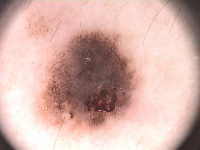</td><td>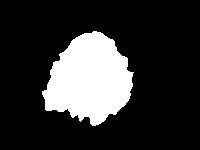</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [10]:
! gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar #беру другую ссылку,две исходных не работали

#альтернативная ссылка на данные: https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 226MB/s] 


In [11]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [12]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [13]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [14]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [15]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

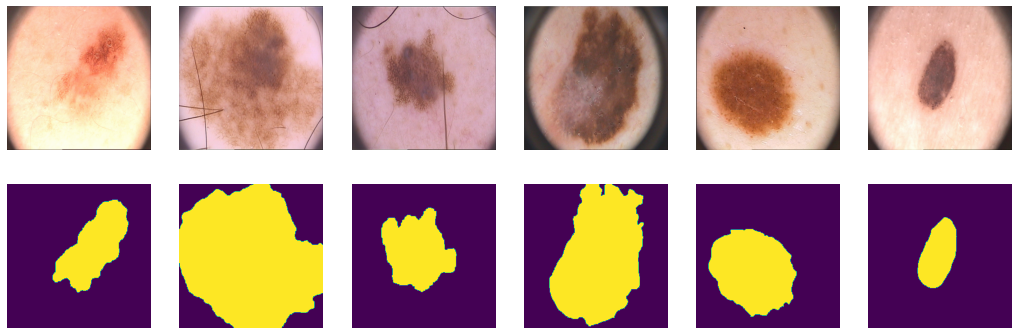

In [16]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [17]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [18]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [19]:
from torch.utils.data import DataLoader
batch_size = 10 #уменьшил размер батча,чтобы не было переполнений
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [20]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

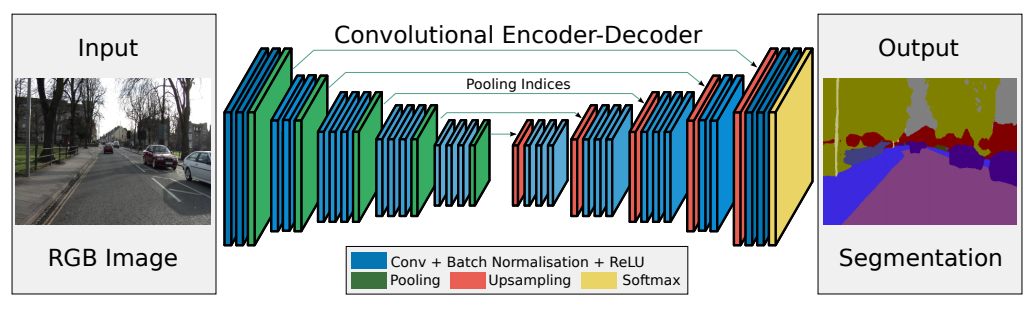

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [21]:
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [22]:
#Реализуем стандартный SegNet,горлышко для удобства разбил на 2
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(*[
                                                nn.Conv2d(3, 64,
                                                          kernel_size = 3,
                                                          padding = 1),
                                                nn.BatchNorm2d(64, momentum = 0.1), 
                                                nn.ReLU(inplace = True),
                                                nn.Conv2d(in_channels = 64,
                                                          out_channels = 64,
                                                          kernel_size = 3,
                                                          padding = 1),
                                                nn.BatchNorm2d(64, momentum = 0.1),
                                                nn.ReLU(inplace = True)             
                                                ])
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices = True)
        self.enc_conv1 = nn.Sequential(*[   
                                                nn.Conv2d(64, 128,
                                                          kernel_size = 3,
                                                          padding = 1),
                                                nn.BatchNorm2d(128, momentum = 0.1),
                                                nn.ReLU(inplace = True),
                                                nn.Conv2d(in_channels = 128,
                                                          out_channels = 128,
                                                          kernel_size = 3,
                                                          padding = 1),
                                                nn.BatchNorm2d(128, momentum = 0.1),
                                                nn.ReLU(inplace = True),
                                                nn.Conv2d(in_channels = 128,
                                                          out_channels = 256,
                                                          kernel_size = 3,
                                                          padding = 1),
                                                nn.BatchNorm2d(256,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                                
                                                ])
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(256,256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256,momentum=0.1),  
                                                nn.ReLU(inplace=True),                                  
                                                ])
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv3 =nn.Sequential(*[
                                                 nn.Conv2d(in_channels=256,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                 nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512,momentum=0.1),
                                                nn.ReLU(inplace=True),

                                                ])
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv1=nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512),
                                                nn.ReLU(inplace=True)])
        self.bottlepool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleupsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.bottleneck_conv2=nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512),
                                                nn.ReLU(inplace=True)])
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(*[
                                                 nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                 nn.Conv2d(in_channels=512,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256,momentum=0.1),
                                                nn.ReLU(inplace=True),

                                                ]) 
        self.upsample1 =nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(256,256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256,momentum=0.1),  
                                                nn.ReLU(inplace=True),                                  
                                                ])
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(*[   
                                                nn.Conv2d(256,128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64,momentum=0.1),
                                                nn.ReLU(inplace=True),
                                                                
                                                ])
        self.upsample3 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 =nn.Sequential(*[
                                                nn.Conv2d(64,64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64,momentum=0.1), 
                                                nn.ReLU(inplace=True),
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=1,
                                                          kernel_size=3,
                                                          padding=1),             
                                                ])

    def forward(self, x):
        # encoder
        e0,indices0 = self.pool0(self.enc_conv0(x))
        e1,indices1 = self.pool1(self.enc_conv1(e0))
        e2,indices2 = self.pool2(self.enc_conv2(e1))
        e3,indices3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b1,indices4 = self.bottlepool(self.bottleneck_conv1(e3))
        b2 = self.upsample0(self.bottleneck_conv2(self.bottleupsample((b1),indices4)),indices3)


        # decoder
        d0 = self.upsample1(self.dec_conv0(b2),indices2)
        d1 = self.upsample2(self.dec_conv1(d0),indices1)
        d2 = self.upsample3(self.dec_conv2(d1),indices0)
        d3 = self.dec_conv3(d2)
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [23]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [24]:
#на всякий случай перевел вычисления на cpu
def bce_loss(y_pred, y_real):
    y_real = y_real.to('cpu')
    y_pred = y_pred.to('cpu')
    result = torch.mean(y_pred-y_real*y_pred+torch.log(1+torch.exp(-y_pred)))
    return result
    

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [47]:
def train(model, opt, epochs,loss_fn,data_tr, data_val,name_loss_fn):
    X_val, Y_val = next(iter(data_val))
    loss_history=[] #для графика loss'ов

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:

            # data to device
            X_batch=X_batch.to(device)
            Y_batch=Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred =model(X_batch)
            loss = loss_fn(Y_pred,Y_batch)
            loss.backward()
            opt.step()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            X_batch = X_batch.cpu()
            Y_batch = Y_batch.cpu()
            Y_pred = Y_pred.cpu()
            del X_batch, Y_batch, Y_pred, loss #чтобы не переполнять GPU
            torch.cuda.empty_cache()
        toc = time()
        print('loss: %f' % avg_loss)
        loss_history.append(avg_loss)
        model.eval()  # testing mode
        with torch.no_grad():
          Y_hat = (torch.sigmoid(model(X_val.detach().to(device)))>0.5).type(torch.int64).to('cpu')
        # Visualize tools
        torch.cuda.empty_cache()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    print()
    loss_history = np.array(loss_history) 
    plt.figure(figsize=(6, 4)) 
    plt.plot(range(len(loss_history)), loss_history) 
    plt.xlabel("Epochs") 
    plt.ylabel("Loss") 
    plt.title(name_loss_fn) 
    plt.grid() 
    plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [30]:
def predict(model, data):
    with torch.no_grad():
      model.eval()  # testing mode
      Y_pred = [ X_batch for X_batch, _ in data]
      return np.array(Y_pred)

In [26]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    with torch.no_grad():
      scores = 0
      for X_batch, Y_label in data:
          Y_pred = (torch.sigmoid(model(X_batch.detach().to(device)))>0.5).type(torch.int64) #записываем предикты
          scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [48]:
model = SegNet().to(device)

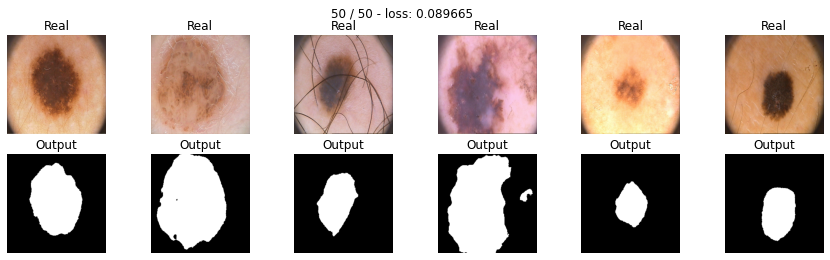

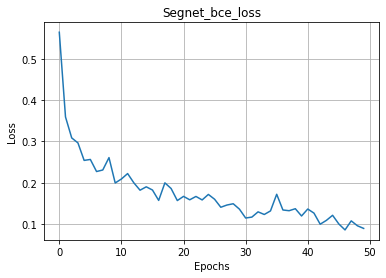

In [49]:
max_epochs = 50
optim=torch.optim.Adam(model.parameters(),lr=3e-4)
train(model, optim, max_epochs,bce_loss, data_tr, data_val,"Segnet_bce_loss") # обучаем

In [50]:
print(score_model(model, iou_pytorch, data_val))
gc.collect()
torch.cuda.empty_cache()

0.712000024318695


Ответьте себе на вопрос: не переобучается ли моя модель?

In [ ]:
#При небольшом количестве эпох(до 120-150) модель не переобучается

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [51]:
 def dice_loss(Y_pred, Y_real): 
       smooth = 1.
       Y_pred=torch.sigmoid(Y_pred)
       iflat = Y_pred.contiguous().view(-1)
       tflat = Y_real.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat*iflat)
       B_sum = torch.sum(tflat*tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

Проводим тестирование:

In [57]:
model_dice = SegNet().to(device)

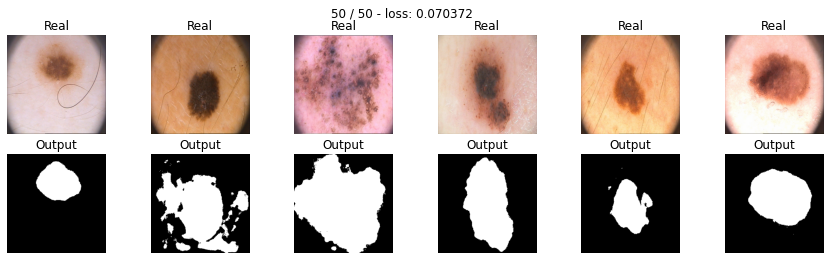

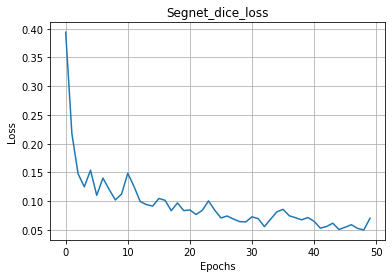

In [59]:

max_epochs = 50
optimaizer = torch.optim.AdamW(model_dice.parameters(),lr=3e-4)
train(model_dice, optimaizer, max_epochs, dice_loss, data_tr, data_val,'Segnet_dice_loss')

In [69]:
print(score_model(model_dice, iou_pytorch, data_val))
gc.collect()
torch.cuda.empty_cache()

0.6420000314712524


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [61]:
def focal_loss(y_pred,y_real,eps=1e-3,gamma=2):
    y_pred=torch.sigmoid(y_pred)
    loss=(1-torch.exp(-bce_loss(y_pred,y_real))**gamma*bce_loss(y_pred,y_real))
    return loss

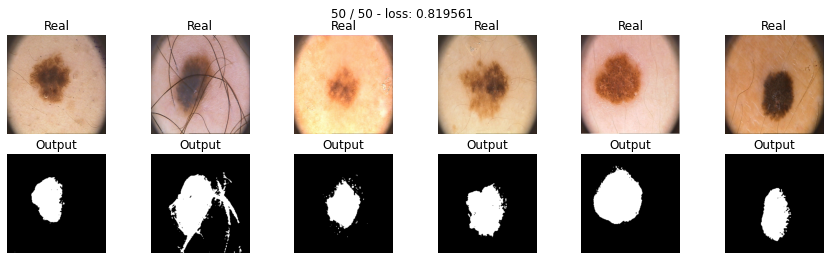

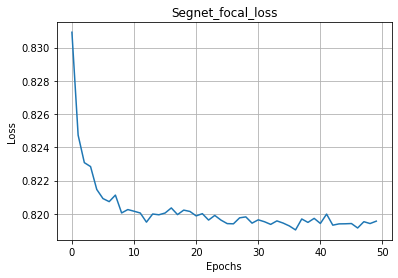

In [62]:
model_focal = SegNet().to(device)

max_epochs = 50
optimaizer = torch.optim.Adam(model_focal.parameters(),lr=4e-3)
train(model_focal, optimaizer, max_epochs, focal_loss, data_tr, data_val, 'Segnet_focal_loss')

In [63]:

gc.collect()
torch.cuda.empty_cache()

In [64]:
score_model(model_focal, iou_pytorch, data_val)

0.5460000336170197

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

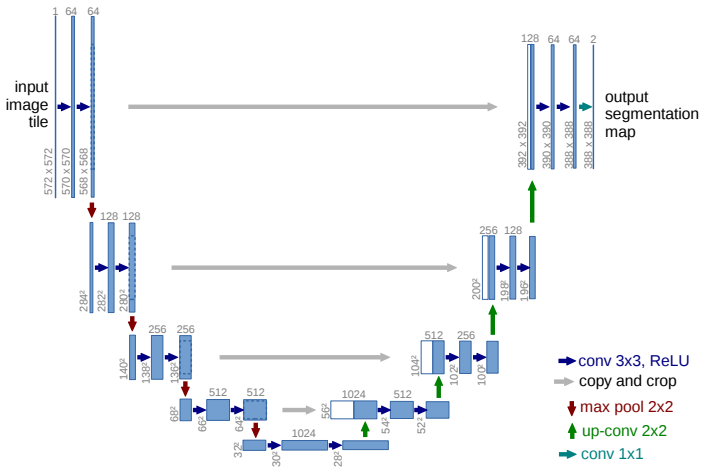

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [65]:
#Возьмем стандартную реализацию U-net (писал не сам,взял с гитхаба)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [72]:
unet_model_bce = UNET().to(device)

In [67]:
gc.collect()
torch.cuda.empty_cache()

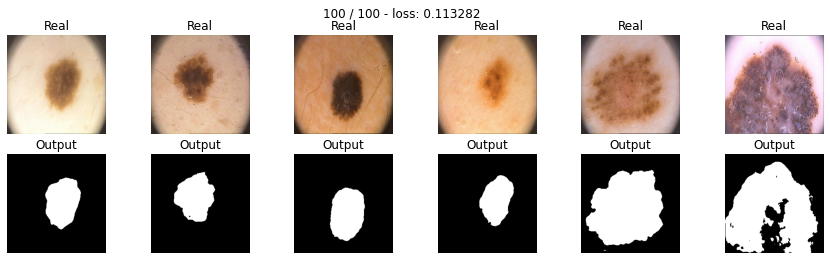

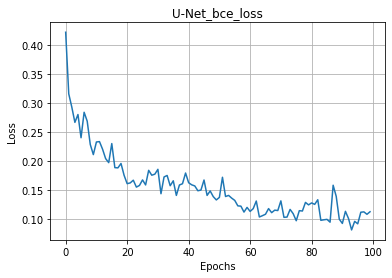

In [73]:
train(unet_model_bce, torch.optim.Adam(unet_model_bce.parameters()),100, bce_loss, data_tr, data_val,'U-Net_bce_loss')

In [74]:
score_model(unet_model_bce, iou_pytorch, data_val)

0.7560000538825988

Теперь проверьте модель UNet c функцией потерь FocalLoss. 

In [75]:
unet_model_focal= UNET().to(device)


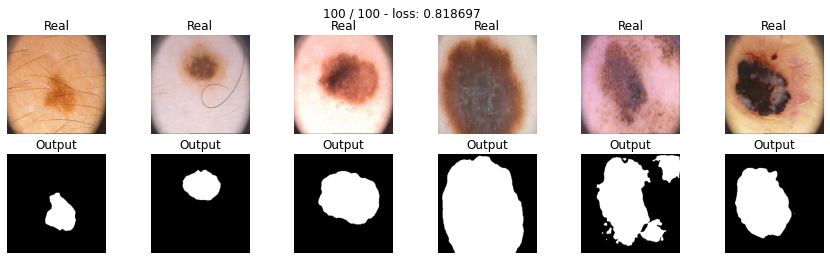

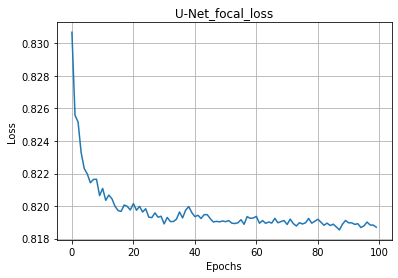

In [76]:
train(unet_model_focal, torch.optim.Adam(unet_model_focal.parameters()),100, focal_loss, data_tr, data_val,'U-Net_focal_loss')

In [78]:
score_model(unet_model_focal, iou_pytorch, data_val)

0.6820000410079956

Сделайте вывод, какая из моделей лучше.

### **Отчёт**
0. Проделав данный ноутбук, реализовал сверточные модели SegNet и U-Net. При их реализации вдохновлялся официальной документацией и разными реализациями с гитхаба. Помимо этого,  реализовал BCE_loss,Dice_loss,Focal_loss. По моему мнению, все реализовано верно.Во время выполнения задания, много всего пробовал,было куча ошибок. Если честно, думаю то что получилось это процентов 10-15 от всех моих идей, остальные у меня не получались, не работали, либо требовали исправления. Вот так, потратенные часов 20-25 на выполнение данного ноутбука,  привели к следующему:
1. Я ожидал получить focal_loss как наиболее подходящую для наших задач loss функцию.Также хотел увидеть очевидное преимущество U-net над SegNet
2. Мои результаты не совсем удачные и корректные.Во-первых,я понял только недавно,что наиболее подходящее количество эпох для обучения этих  моделей около 100.Но,чтобы не ждать обучения я обучал SegNet на 50 эпохах,U-Net на 100 эпохах , поэтому думаю мои сравнения и результаты не совсем корректны.
3.**Я хотел узнать,какая лосс функция наиболее подходящаа для нашей задачи**. Ей оказалась **BCE_loss**. По метрике score лучшей моделью стала U-Net с BCE_loss (score=0,75).Segnet с BCE_loss  выдал score=0,71. При обучении моделей с другими лоссами,скор не доходил даже до 0,7.Думаю, модели выдавали бы результат сильно лучше,имея мы хотя бы 900-1000 картинок.
4. Также сравнил SegNet и U-Net, построив графики их лоссов (BCE и Focal)
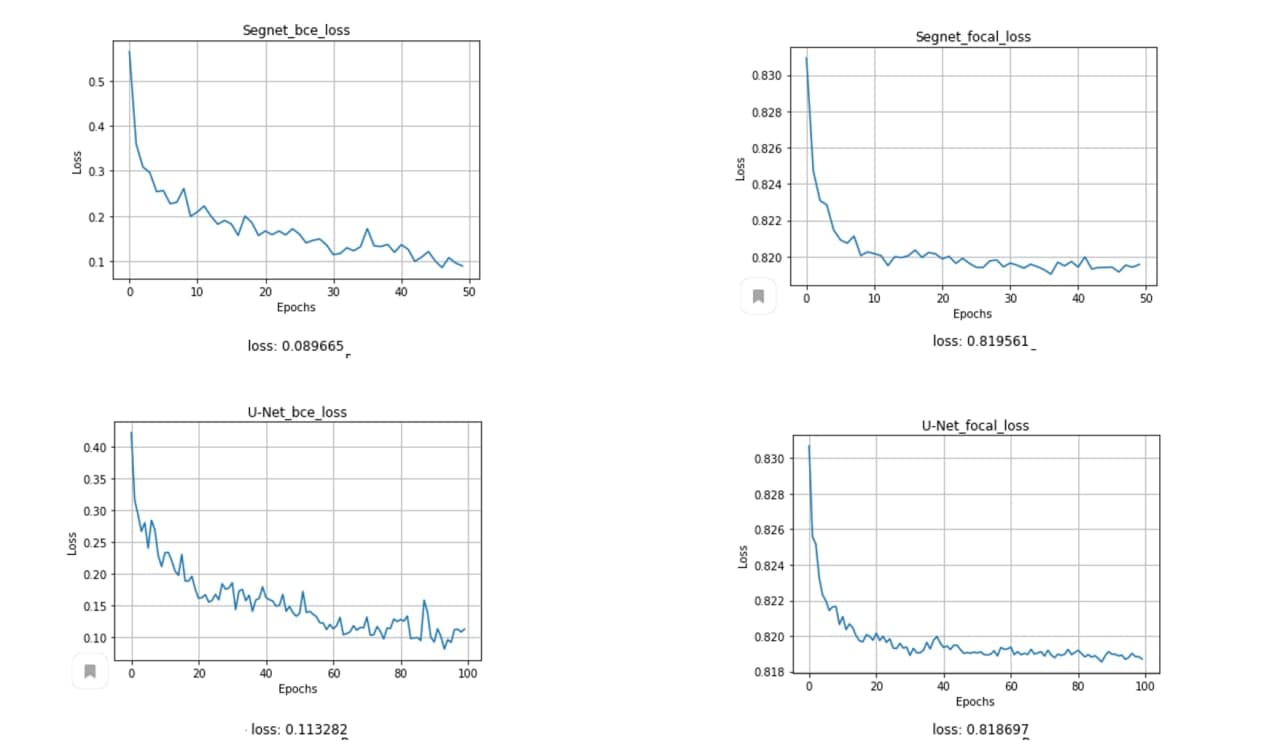
Результаты получились не те,что я ожидал.Видимо из-за того что обучал на малом количестве эпох и выборка была довольно маленькой
5. В заключении хочу сказать, что эта домашка принесла мне коллосальное удовольствие, интересно было эксперементировать с моделями. Проделанная работа получилась недостаточно объемной и детальной из-за того, что обучал на маленьком количестве эпох и сравнивал не совсем корректно, сел за нее всего лишь за 4 дня до дедлайна и часто не совсем понимал, иногда совсем не понимал, что делать))) Отчасти этим мне нравятся ваши домашки. Они прокачивают умение найти, разобраться, погуглить, почитать и решить задачу, которая изначально казалась дикой.
Спасибо вам, команда ДЛС!